In [3]:
# !wget https://datahack-prod.s3.amazonaws.com/train_file/train_go05W65.csv
# !wget https://datahack-prod.s3.amazonaws.com/test_file/test_VkM91FT.csv

# Problem Statement
XYZ Bank is a mid-sized private bank that includes a variety of banking products, such as savings accounts, current accounts, investment products, credit products, and home loans.

The Bank wants to predict the next set of products for a set of customers to optimize their marketing and communication campaigns.

The data available in this problem contains the following information:

User Demographic Details : Gender, Age, Vintage, Customer Category etc.
Current Product Holdings
Product Holding in Next 6 Months (only for Train dataset)
Here, our task is to predict the next set of products (upto 3 products) for a set of customers (Test data) based on their demographics and current product holdings.

# DataSet Description
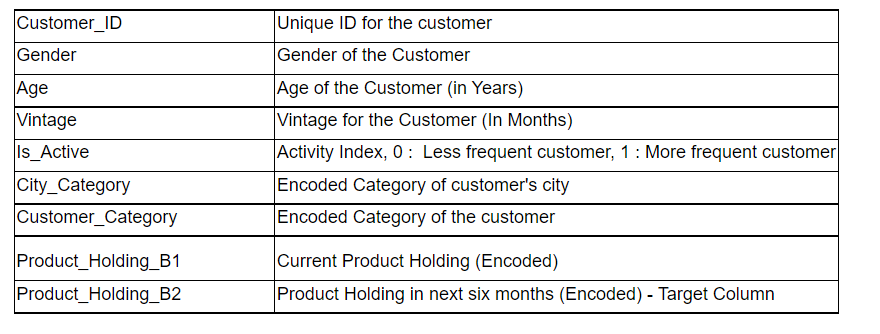

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re
pd.options.display.max_columns=100

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [5]:
raw_train = pd.read_csv("train_go05W65.csv")
raw_test = pd.read_csv("test_VkM91FT.csv")
raw_train.head(3)

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
0,CC264719,Male,41,14,0,C1,S3,['P16'],['P8']
1,CC209679,Female,47,14,1,C1,S2,"['P13', 'P20']",['P3']
2,CC319633,Female,59,14,0,C2,S2,['P11'],['P00']


In [6]:
raw_train.shape

(37748, 9)

In [7]:
raw_test.head(3)

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1
0,CC372708,Female,31,31,0,C2,S3,"['P12', 'P13']"
1,CC216072,Male,28,37,1,C1,S2,"['P12', 'P13']"
2,CC387629,Male,31,12,0,C2,S3,['P20']


In [8]:
raw_test.shape

(20327, 8)

In [9]:
set(raw_train['Customer_ID'].unique()).intersection(set(raw_test['Customer_ID'].unique()))

set()

In [10]:
raw_train.describe()

,Age,Vintage,Is_Active
count,37748.000000,37748.000000,37748.000000
mean,38.521379,19.573169,0.264809
std,10.121811,10.252417,0.441237
min,24.000000,2.000000,0.000000
25%,29.000000,13.000000,0.000000
50%,37.000000,16.000000,0.000000
75%,47.000000,23.000000,1.000000
max,59.000000,65.000000,1.000000


In [11]:
raw_train.describe(include=np.object)

,Customer_ID,Gender,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
count,37748,37748,37748,37748,37748,37748
unique,37748,2,2,3,617,495
top,CC292291,Male,C1,S3,['P13'],['P00']
freq,1,25890,18941,17865,7443,5908


In [12]:
def parse_holding(df,input_col,output_col):
    df = df.copy()

    for idx, row in df.iterrows():
        print(f"\rProcessing {idx+1}/{df.shape[0]}",end='')
        products= row[input_col]
        products = re.findall("'([^']*)'", products)
        for item in products:
            item_col = f"{output_col}_{item}"
            if item_col not in df.columns:
                df[item_col] = 0
            df.at[idx,item_col] = 1 + df.at[idx,item_col]
    return df

In [13]:
train_df = parse_holding(raw_train,input_col='Product_Holding_B1',output_col='B1')
train_df = parse_holding(train_df,input_col='Product_Holding_B2',output_col='B2')
train_df.head(3)

Processing 37748/37748

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
0,CC264719,Male,41,14,0,C1,S3,['P16'],['P8'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CC209679,Female,47,14,1,C1,S2,"['P13', 'P20']",['P3'],0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CC319633,Female,59,14,0,C2,S2,['P11'],['P00'],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
test_df = parse_holding(raw_test,input_col='Product_Holding_B1',output_col='B1')
test_df.head(3)

Processing 20327/20327

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,B1_P12,B1_P13,B1_P20,B1_P21,B1_P17,B1_P16,B1_P10,B1_P19,B1_P8,B1_P11,B1_P15,B1_P9,B1_P2,B1_P00,B1_P7,B1_P14,B1_P18,B1_P3,B1_P4,B1_P6,B1_P5,B1_P1
0,CC372708,Female,31,31,0,C2,S3,"['P12', 'P13']",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CC216072,Male,28,37,1,C1,S2,"['P12', 'P13']",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CC387629,Male,31,12,0,C2,S3,['P20'],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
b1_products = train_df.columns[train_df.columns.str.startswith('B1')]
b1_products

Index(['B1_P16', 'B1_P13', 'B1_P20', 'B1_P11', 'B1_P8', 'B1_P17', 'B1_P21',
       'B1_P12', 'B1_P10', 'B1_P19', 'B1_P2', 'B1_P00', 'B1_P18', 'B1_P15',
       'B1_P6', 'B1_P9', 'B1_P7', 'B1_P3', 'B1_P5', 'B1_P4', 'B1_P1',
       'B1_P14'],
      dtype='object')

In [16]:
len(b1_products)

22

In [17]:
b2_products = train_df.columns[train_df.columns.str.startswith('B2')]
b2_products

Index(['B2_P8', 'B2_P3', 'B2_P00', 'B2_P6', 'B2_P12', 'B2_P16', 'B2_P1',
       'B2_P9', 'B2_P10', 'B2_P13', 'B2_P4', 'B2_P5', 'B2_P7', 'B2_P11',
       'B2_P2', 'B2_P15', 'B2_P17', 'B2_P14', 'B2_P20', 'B2_P18'],
      dtype='object')

In [18]:
drop_col = ['Product_Holding_B1','Product_Holding_B2','Customer_ID'] + list(b2_products)
x_train = train_df.drop(drop_col,axis=1)
x_train.head(3)

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14
0,Male,41,14,0,C1,S3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Female,47,14,1,C1,S2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Female,59,14,0,C2,S2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
drop_col = ['Product_Holding_B1','Customer_ID']
x_test = test_df.drop(drop_col,axis=1)
x_test.head(3)

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,B1_P12,B1_P13,B1_P20,B1_P21,B1_P17,B1_P16,B1_P10,B1_P19,B1_P8,B1_P11,B1_P15,B1_P9,B1_P2,B1_P00,B1_P7,B1_P14,B1_P18,B1_P3,B1_P4,B1_P6,B1_P5,B1_P1
0,Female,31,31,0,C2,S3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Male,28,37,1,C1,S2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Male,31,12,0,C2,S3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
x_train.shape, x_test.shape

((37748, 28), (20327, 28))

In [22]:
cat_cols = ['Gender','City_Category','Customer_Category']

le = preprocessing.OneHotEncoder(handle_unknown='ignore')

encoded = le.fit_transform(x_train[cat_cols].astype(str))
temp = pd.DataFrame(encoded.todense(),columns=le.get_feature_names())
x_train = pd.concat([x_train,temp],axis=1,ignore_index=False,sort=False)

encoded = le.transform(x_test[cat_cols].astype(str))
temp = pd.DataFrame(encoded.todense(),columns=le.get_feature_names())
x_test = pd.concat([x_test,temp],axis=1,ignore_index=False,sort=False)

In [23]:
x_train.head(3)

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3
0,Male,41,14,0,C1,S3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,Female,47,14,1,C1,S2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Female,59,14,0,C2,S2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [24]:
x_test.head(3)

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,B1_P12,B1_P13,B1_P20,B1_P21,B1_P17,B1_P16,B1_P10,B1_P19,B1_P8,B1_P11,B1_P15,B1_P9,B1_P2,B1_P00,B1_P7,B1_P14,B1_P18,B1_P3,B1_P4,B1_P6,B1_P5,B1_P1,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3
0,Female,31,31,0,C2,S3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Male,28,37,1,C1,S2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,Male,31,12,0,C2,S3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [25]:
y_train = train_df[b2_products].copy()
y_train.head(3)

,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
x_test = x_test.drop(cat_cols,axis=1)
x_train = x_train.drop(cat_cols,axis=1)

In [27]:
xgb_model = XGBClassifier(n_estimators=100)
xgb_multilabel = MultiOutputClassifier(xgb_model)
xgb_multilabel.fit(x_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                                              subsample=

In [28]:
xgb_predict = xgb_multilabel.predict(x_train)
print(classification_report(y_train, xgb_predict,target_names=b2_products))

              precision    recall  f1-score   support

       B2_P8       0.78      0.37      0.50     11518
       B2_P3       0.66      0.09      0.16      2486
      B2_P00       0.91      0.36      0.51      5908
       B2_P6       0.71      0.34      0.46      4675
      B2_P12       0.82      0.74      0.78      7285
      B2_P16       0.87      0.76      0.81      3478
       B2_P1       0.69      0.20      0.31      3310
       B2_P9       0.62      0.08      0.15      1833
      B2_P10       0.65      0.15      0.24      2914
      B2_P13       0.95      0.45      0.61      1494
       B2_P4       0.71      0.19      0.29      2943
       B2_P5       0.64      0.10      0.17      1211
       B2_P7       0.71      0.20      0.31      2526
      B2_P11       0.78      0.13      0.23       186
       B2_P2       0.84      0.34      0.48       206
      B2_P15       0.00      0.00      0.00        41
      B2_P17       1.00      0.06      0.11        17
      B2_P14       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_multilabel = MultiOutputClassifier(lgb_model)
lgb_multilabel.fit(x_train, y_train)

MultiOutputClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.1, max_depth=-1,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0.0,
                                               n_estimators=100, n_jobs=-1,
                                               num_leaves=31, objective=None,
                                               random_state=42, reg_alpha=0.0,
                                               reg_lambda=0.0, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=2

In [30]:
lgb_predict = lgb_multilabel.predict(x_train)
print(classification_report(y_train, lgb_predict,target_names=b2_products))

              precision    recall  f1-score   support

       B2_P8       0.74      0.49      0.59     11518
       B2_P3       0.82      0.14      0.25      2486
      B2_P00       0.79      0.53      0.63      5908
       B2_P6       0.76      0.38      0.51      4675
      B2_P12       0.83      0.79      0.81      7285
      B2_P16       0.85      0.93      0.89      3478
       B2_P1       0.76      0.27      0.40      3310
       B2_P9       0.84      0.14      0.24      1833
      B2_P10       0.69      0.31      0.43      2914
      B2_P13       0.96      0.56      0.71      1494
       B2_P4       0.78      0.25      0.38      2943
       B2_P5       0.82      0.16      0.26      1211
       B2_P7       0.81      0.27      0.40      2526
      B2_P11       0.99      0.91      0.95       186
       B2_P2       0.99      0.92      0.95       206
      B2_P15       0.97      0.73      0.83        41
      B2_P17       0.09      0.65      0.15        17
      B2_P14       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
b2_products = train_df[b2_products].sum().index

In [32]:
b1 = [i.split('_')[-1] for i in b1_products]
b2 = [i.split('_')[-1] for i in b2_products]
only_b1 = list(set(b1)-set(b2))
only_b1

['P19', 'P21']

In [62]:
def get_prediction(df,b1_products=b1_products,only_b1=only_b1,min_score=0):
    df = df.copy()
    for idx,b1_item in enumerate(b1_products):
        if b1_item.split('_')[-1] not in only_b1:
            
            b2_item = b1_item.replace("B1","B2")
            df[b2_item] = np.where(df[b2_item] <min_score,np.nan,df[b2_item])
            df[b2_item] = np.where(df[b1_item]==1,np.nan,df[b2_item])

    df['Product_Holding_B2'] = ''
    for idx,row in df.iterrows():
        top_3 = list(row[b2_products].astype(float).nlargest(3).index)
        top_3 = [i.split('_')[-1] for i in top_3]
        df.at[idx,'Product_Holding_B2'] = top_3  
    
    return df

In [63]:
submission = x_test[b1_products].copy()
submission['Customer_ID'] = raw_test['Customer_ID']

lgb_test = lgb_multilabel.predict_proba(x_test)
for idx,item in enumerate(b2_products):
    proba = lgb_test[idx]
    submission[item] = proba[:,1]

submission = get_prediction(submission)

In [64]:
submission.sample(3)

,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,Customer_ID,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18,Product_Holding_B2
16001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CC282458,0.012042,0.003170,0.002943,0.003264,0.033400,NaN,0.001914,0.006958,0.002748,0.26408,0.001405,0.000387,0.002112,0.000195,0.002506,4.945300e-06,1.098926e-132,0.0,0.0,0.0,"[P13, P12, P8]"
622,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CC310500,0.392542,0.075459,0.110199,0.132662,0.080572,0.000009,0.010494,0.155563,0.015101,NaN,0.011047,0.005291,0.016731,0.000002,0.000002,2.923008e-07,5.516467e-280,0.0,0.0,0.0,"[P8, P9, P6]"
13243,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CC374727,0.434360,0.029408,0.005248,0.110297,0.629253,0.000009,0.028531,0.163804,0.033152,NaN,0.023219,0.009951,0.058523,0.000003,0.000002,1.497365e-73,0.000000e+00,0.0,NaN,0.0,"[P12, P8, P9]"


In [65]:
lgb_output = submission[['Customer_ID','Product_Holding_B2']].copy()
lgb_output.sample(5)

,Customer_ID,Product_Holding_B2
5119,CC308698,"[P13, P8, P7]"
6475,CC353857,"[P13, P8, P12]"
11610,CC376963,"[P8, P9, P6]"
11750,CC379870,"[P00, P8, P6]"
14276,CC396209,"[P13, P12, P00]"


In [66]:
lgb_output.to_csv("LGB_Results.csv",index=False)

In [67]:
x_train.head(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3
0,41,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,47,14,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,59,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [68]:
x_train[b1_products].head(3)

,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
y_train[b2_products].head(3)

,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
train = pd.concat([x_train,y_train],axis=1,ignore_index=False,sort=False)
df = pd.concat([train,x_test],axis=0,ignore_index=False,sort=False)
df.head(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
0,41,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47,14,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df.tail(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
20324,26,12,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20325,44,19,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20326,25,21,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df.shape[0] == raw_train.shape[0]+raw_test.shape[0]

True

In [73]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

In [74]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
imputed_df = imputer.fit_transform(scaled_df)
imputed_df = pd.DataFrame(imputed_df,columns=df.columns)
imputed_df.tail(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18
58072,0.057143,0.128205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.4,0.200000,0.0,0.0,0.00000,0.2,0.000000,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58073,0.571429,0.217949,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.600809,0.0,0.0,0.40354,0.0,0.000000,0.0,0.0,0.0,0.399178,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58074,0.028571,0.243590,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.713807,0.0,0.286193,0.0,0.0,0.00000,0.0,0.135681,0.0,0.0,0.0,0.123714,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
customer = pd.concat([raw_train['Customer_ID'],raw_test['Customer_ID']],axis=0,ignore_index=True,sort=False)
customer.head(3)

0    CC264719
1    CC209679
2    CC319633
Name: Customer_ID, dtype: object

In [76]:
imputed_df['Customer_ID'] = customer
imputed_df.head(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18,Customer_ID
0,0.485714,0.153846,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC264719
1,0.657143,0.153846,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC209679
2,1.000000,0.153846,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC319633


In [77]:
knn_output = imputed_df[imputed_df['Customer_ID'].isin(raw_test['Customer_ID'])].copy()
knn_output.head(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18,Customer_ID
37748,0.200000,0.371795,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.518262,0.000000,0.0,0.000000,0.0,0.0,0.212774,0.000000,0.000000,0.0,0.268964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC372708
37749,0.114286,0.448718,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.581924,0.270589,0.0,0.144925,0.0,0.0,0.394362,0.147487,0.190124,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC216072
37750,0.200000,0.128205,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC387629


In [78]:
knn_output.shape[0] == raw_test.shape[0]

True

In [79]:
knn_predict = get_prediction(knn_output)
knn_predict.head(3)

,Age,Vintage,Is_Active,B1_P16,B1_P13,B1_P20,B1_P11,B1_P8,B1_P17,B1_P21,B1_P12,B1_P10,B1_P19,B1_P2,B1_P00,B1_P18,B1_P15,B1_P6,B1_P9,B1_P7,B1_P3,B1_P5,B1_P4,B1_P1,B1_P14,x0_Female,x0_Male,x1_C1,x1_C2,x2_S1,x2_S2,x2_S3,B2_P8,B2_P3,B2_P00,B2_P6,B2_P12,B2_P16,B2_P1,B2_P9,B2_P10,B2_P13,B2_P4,B2_P5,B2_P7,B2_P11,B2_P2,B2_P15,B2_P17,B2_P14,B2_P20,B2_P18,Customer_ID,Product_Holding_B2
37748,0.200000,0.371795,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.518262,0.000000,0.0,0.000000,NaN,0.0,0.212774,0.000000,0.000000,NaN,0.268964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC372708,"[P8, P4, P1]"
37749,0.114286,0.448718,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.581924,0.270589,0.0,0.144925,NaN,0.0,0.394362,0.147487,0.190124,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC216072,"[P8, P1, P3]"
37750,0.200000,0.128205,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,CC387629,"[P13, P8, P3]"


In [51]:
knn_predict[['Customer_ID','Product_Holding_B2']].to_csv("knn_impute.csv",index=False)

In [ ]:
# U, S, V = np.linalg.svd(X.todense())